<div class="alert alert-info">
View notebook in interactive mode for using hyperlinks and correct display of markdown:<br>
<a href='https://nbviewer.org/github/yulianikola/portfolio/blob/master/english/data_analysis_python/hypothesis/AB_test_cookie_eng.ipynb'>AB_test_cookie</a></div>

### АВ-test
#### Mobile game Cookie Cats

<p style="align: center;"><img align=center src="https://i.ytimg.com/vi/iPxZIp0cbJE/maxresdefault.jpg"  width=500></p>
 
 
<p style="align: center;"><img align=center src="https://s3.amazonaws.com/assets.datacamp.com/production/project_184/img/cc_gates.png"  width=500></p>


<div class="alert alert-info">
As players progress through the game's levels, they occasionally encounter gates that make them wait a non-trivial amount of time or make in-app purchases to continue. In addition to encouraging in-app purchases, these gates serve the important purpose of giving players a forced break in the game, which will hopefully lead to increased and prolonged enjoyment of the game.
</div>

<div class="alert alert-info">
<b>But where to place the gate?</b>
Originally, the first gate was placed at level 30. The task is to analyze the AB test, in which the creators moved the first gate in Cookie Cats from level 30 to level 40. Specifically, you need to look at the impact of the A/B test on player retention.
</div>

**Data collected from 90 189 players who installed the game during the AB test. Variables:**

* `userid` - player identification number

* `version` - whether player in control group (gate_30 - gate at level 30) or test group (gate_40 - gate at level 40).

* `sum_gamerounds` - number of played rounds during the first week after installation 
* `retention_1` - player came back and played 1 day after installation?
* `retention_7` - player came back and played 7 days after installation?

When a player installed the game, he was randomly assigned `gate_30` или `gate_40`.

<h4>Table of contents</h4><br>
<p id="0">
<ul type="square"><a href="#1"><li>Explore the data</li></a>
<a href="#2"><li>Impact on retention (Pearson's chi-squared)</li></a>
    <ul><a href="#2.1"><li>1 day after</li></a>
    <a href="#2.2"><li>7 days after</li></a></ul>
<a href="#3"><li>Impact on number of rounds</li></a> 
    <ul><a href="#3.1"><li>Student's t-test</li></a>
    <a href="#3.2"><li>Mann-Whitney u-test</li></a>
    <a href="#3.3"><li>Log transformation</li></a></ul>
<a href="#4"><li>Conclusion</li></a>

In [1]:
import numpy as np
import pandas as pd
import scipy.stats as stats 
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
data = pd.read_csv('c:\\python\\portfolio\\data_analysis_python\\3_hypothesis\\data\\cookie_cats.csv')
data.head()

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True


<p id="1">
<h4>EDA</h4><br>

The dataset contains 90189 rows, no nulls. The userid and sum_gamerounds columns are defined of numeric type, so there are no non-numeric characters among the values, which can represent missing values:

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90189 entries, 0 to 90188
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   userid          90189 non-null  int64 
 1   version         90189 non-null  object
 2   sum_gamerounds  90189 non-null  int64 
 3   retention_1     90189 non-null  bool  
 4   retention_7     90189 non-null  bool  
dtypes: bool(2), int64(2), object(1)
memory usage: 2.2+ MB


Based on the values of categorical type columns, there are no "non-standard" nulls like "?":

In [5]:
print(data.version.unique())
print('')
print(data.retention_1.unique())
print('')
print(data.retention_7.unique())

['gate_30' 'gate_40']

[False  True]

[False  True]


Column userid does not contain duplicates, as number of unique values equal number of rows. Thus, there are no users in both the control and test groups:

In [6]:
data.userid.nunique()

90189

Test group contains a bit more players:

In [7]:
data.version.value_counts(normalize = True)

gate_40    0.504374
gate_30    0.495626
Name: version, dtype: float64

Among the players, 45% have returned to the game after one day and 19% after 7 days. At the same time, 51% have not return to the game after 1 or 7 days (but this does not mean that they have not return in between, it just was not recorded):

In [8]:
pd.crosstab(data.retention_1, data.retention_7, normalize = True, margins = True )

retention_7,False,True,All
retention_1,,,
False,0.514885,0.039905,0.55479
True,0.299050,0.146160,0.44521
All,0.813935,0.186065,1.00000


Have a look at the statistics of the only numerical variable the number of rounds played:

In [9]:
data.sum_gamerounds.describe()

count    90189.000000
mean        51.872457
std        195.050858
min          0.000000
25%          5.000000
50%         16.000000
75%         51.000000
max      49854.000000
Name: sum_gamerounds, dtype: float64

The minimum value of rounds played is 0, there are 3994 such players. We can not know if they have returned to the game at all during the experiment. Since we only have a record of returning after one day and after seven, players could have returned in between. Among the people who played 0 rounds, there could be those who have not returned at all and those who have returned but have not complete a single round. We can't find that out, so we keep these players in the dataset.

In [10]:
len(data[data.sum_gamerounds == 0])

3994

Given that 75% of the participants have played no more than 51 rounds each, the maximum is 49854 rounds. There can be errors or outliers. A value of 49854 rounds is the only one that is so different from the other values:

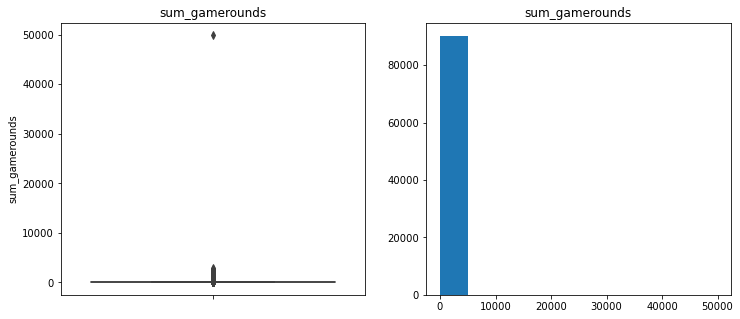

In [11]:
plt.figure(figsize = (12, 5)) 
plt.subplot(1,2,1)
sns.boxplot(y = data.sum_gamerounds);
plt.title('sum_gamerounds');
plt.subplot(1,2,2)
plt.hist(data.sum_gamerounds);
plt.title('sum_gamerounds');

Have a look at the player with such number of rounds. He is from control group, has not returned 1 day later, but has returned 7 days later.

In [12]:
data[data.sum_gamerounds == data.sum_gamerounds.max()]

,userid,version,sum_gamerounds,retention_1,retention_7
57702,6390605,gate_30,49854,False,True


To decide that this is an error, one needs to know how many rounds are possible in this game. But even if that number is possible, it is undoubtedly an outlier, distorting the data. So let's exclude it and call this version of dataset sample_1:

In [13]:
data_1 = data[data.sum_gamerounds < data.sum_gamerounds.max()]

Now let's look at the statistics, the histogram and the boxplot without this outlier. The distribution is still very asymmetric, heavily skewed to the right, with a very long right tail.

In [14]:
data_1.sum_gamerounds.describe()

count    90188.000000
mean        51.320253
std        102.682719
min          0.000000
25%          5.000000
50%         16.000000
75%         51.000000
max       2961.000000
Name: sum_gamerounds, dtype: float64

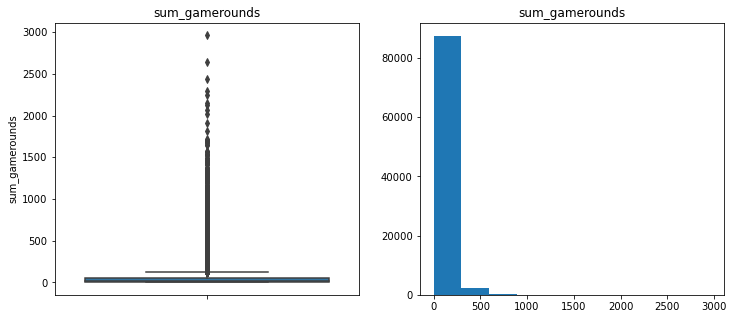

In [15]:
plt.figure(figsize = (12, 5)) 
plt.subplot(1,2,1)
sns.boxplot(y = data_1.sum_gamerounds);
plt.title('sum_gamerounds');
plt.subplot(1,2,2)
plt.hist(data_1.sum_gamerounds);
plt.title('sum_gamerounds');

Calculate the lower bound of the right-tail outliers according to the boxplot calculations and the boundary of the so-called extreme outliers. Even the boundary for extreme outliers is only 189, while the values go up to almost 3000:

In [21]:
up_out = (data_1.sum_gamerounds.describe()['75%'] + 1.5 * (data_1.sum_gamerounds.describe()['75%']
                                                           - data_1.sum_gamerounds.describe()['25%'] ))
up_out_ext = (data_1.sum_gamerounds.describe()['75%'] + 3 * (data_1.sum_gamerounds.describe()['75%']
                                                             - data_1.sum_gamerounds.describe()['25%'] ))
up_out, up_out_ext

(120.0, 189.0)

Let's assume that rounds (rounds played during the week, variable sum_gamerounds) and levels (at which gate is placed, 30th or 40th) are the same thing. The goal of the AB test is to estimate the impact of gate location. In my opinion, if a player has gone through many levels in a week (numbers quite distant from 30 or 40), it is unlikely that his behavior (in terms of number of rounds or retention rate) is related to the gate location. That is, if gate at level 30/40 has an effect, it is unlikely that it will last until 200, 500, 1000, etc levels. So let's make another version of the dataset, excluding players with outliers in sum_gamerounds based on the extreme boundary (call this version of dataset sample_2). Below we will check the robustness of tests to such changes:


In [22]:
data_2 = data_1[data_1.sum_gamerounds < up_out_ext ]

Number of rows reduced from 90189 to 84449:

In [23]:
data_2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 84449 entries, 0 to 90188
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   userid          84449 non-null  int64 
 1   version         84449 non-null  object
 2   sum_gamerounds  84449 non-null  int64 
 3   retention_1     84449 non-null  bool  
 4   retention_7     84449 non-null  bool  
dtypes: bool(2), int64(2), object(1)
memory usage: 2.7+ MB


Statistics of sum_gamerounds after exclusion of outliers:

In [24]:
data_2.sum_gamerounds.describe()

count    84449.000000
mean        30.625703
std         39.138814
min          0.000000
25%          4.000000
50%         14.000000
75%         41.000000
max        188.000000
Name: sum_gamerounds, dtype: float64

After exclusion of outliers the right tail becomes visible on the histogram:

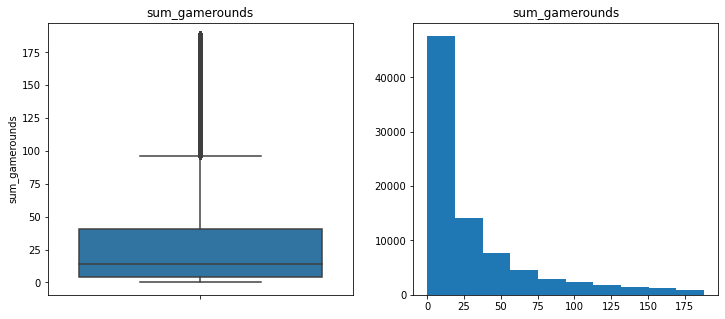

In [25]:
plt.figure(figsize = (12, 5)) 
plt.subplot(1,2,1)
sns.boxplot(y = data_2.sum_gamerounds);
plt.title('sum_gamerounds');
plt.subplot(1,2,2)
plt.hist(data_2.sum_gamerounds);
plt.title('sum_gamerounds');

Distributions of retention variables (1 day / 7 days later) have changed insignificantly after the exclusion of outliers:

In [26]:
pd.crosstab(data_2.retention_1, data_2.retention_7, normalize = True, margins = True )

retention_7,False,True,All
retention_1,,,
False,0.548911,0.039018,0.587929
True,0.309358,0.102713,0.412071
All,0.858269,0.141731,1.000000


Control/test groups ratio remains almost unchanged:

In [27]:
data_2.version.value_counts(normalize = True)

gate_40    0.504612
gate_30    0.495388
Name: version, dtype: float64

<a href="#0"><h4>Back to top</h4></a>

<p id="2">
<h4> Impact on player's retention</h4><br>

Split the data from sample_1 in control and test groups:

In [28]:
gate_30 = data_1[data_1.version == 'gate_30']
gate_40 = data_1[data_1.version == 'gate_40']

Distribution of retention variables are very similar between control and test groups:

In [29]:
pd.crosstab(gate_30.retention_1, gate_30.retention_7, normalize = True, margins = True )

retention_7,False,True,All
retention_1,,,
False,0.510973,0.040829,0.551802
True,0.298843,0.149355,0.448198
All,0.809817,0.190183,1.000000


In [30]:
pd.crosstab(gate_40.retention_1, gate_40.retention_7, normalize = True, margins = True )

retention_7,False,True,All
retention_1,,,
False,0.518741,0.038976,0.557717
True,0.299259,0.143024,0.442283
All,0.818000,0.182000,1.000000


Split the data from sample_2 in control and test groups:

In [31]:
gate_30_2 = data_2[data_2.version == 'gate_30']
gate_40_2 = data_2[data_2.version == 'gate_40']

<a href="#0"><h4>Back to top</h4></a>

<p id="2.1">
<h5>Impact on retention 1 day later (retention_1)</h5><br>

Retention rate is almost the same between control and test groups:

In [32]:
print(gate_30[['version','retention_1']].value_counts(normalize = True))
print(gate_40[['version','retention_1']].value_counts(normalize = True))

version  retention_1
gate_30  False          0.551802
         True           0.448198
dtype: float64
version  retention_1
gate_40  False          0.557717
         True           0.442283
dtype: float64


As we deal with categorical variable and two independent groups, use Pearson's chi-squared test.

* Null hypothesis: independence of retention_1 and gate location, absence of association between them, difference in retention_1 between control and test group is accidental
* Alternative hypothesis: association between retention_1 and gate location, difference in retention_1 between control and test group is not accidental

Prepare contingency table for the test:

In [33]:
cont_matrix_ret1 = pd.crosstab(data_1.version, data_1.retention_1)
cont_matrix_ret1

retention_1,False,True
version,,
gate_30,24665,20034
gate_40,25370,20119


Test is non-parametric and does not require normality of distribution. Contingency table is a 2 by 2 matrix, but every cell has signficant count, so there is no need in Yate's correction.

In [34]:
stats.chi2_contingency(cont_matrix_ret1, correction = False)

(3.19373895460949,
 0.07392076034183397,
 1,
 array([[24798.35970417, 19900.64029583],
        [25236.64029583, 20252.35970417]]))

* If H0 is true (difference between groups is accidental), the probability of seeing this test statistic (or something more extreme) is about 7%
* Hereinafter choose the conventional significance level of 5%
* Given the 5% significance level there is not enough evidence for rejecting the Null
* Fail to reject H0 in favor of H1
* Difference in retention_1 between control and test groups is accidental. There is no association between gate location and retention. Numbers of returned and not returned players in group gate_30 does not differ (statistically) significantly from numbers in group gate_40.

It is considered to be a p-hacking in statistics, but let's conduct the test for sample_2 as a robustness check:

In [35]:
cont_matrix_ret1_2 = pd.crosstab(data_2.version, data_2.retention_1)
cont_matrix_ret1_2

retention_1,False,True
version,,
gate_30,24481,17354
gate_40,25169,17445


P-value is higher (11%), but we still fail to reject H0:

In [36]:
stats.chi2_contingency(cont_matrix_ret1_2, correction = False)

(2.5859146143058958,
 0.10781811314914272,
 1,
 array([[24596.00172885, 17238.99827115],
        [25053.99827115, 17560.00172885]]))

Retention rate of players 1 day after the installation is not as important for the business as longer-term retention. Retention rate 7 days later is of greater interest.

<a href="#0"><h4>Back to top</h4></a>

<p id="2.2">
<h5>Impact on retention 7 days later (retention_7)</h5><br>

Retention rate is almost the same between control and test groups - 19%:

In [37]:
print(gate_30[['version','retention_7']].value_counts(normalize = True))
print(gate_40[['version','retention_7']].value_counts(normalize = True))

version  retention_7
gate_30  False          0.809817
         True           0.190183
dtype: float64
version  retention_7
gate_40  False          0.818
         True           0.182
dtype: float64


* Null hypothesis: independence of retention_7 and gate location, absence of association between them, difference in retention_7 between control and test group is accidental
* Alternative hypothesis: association between retention_7 and gate location, difference in retention_7 between control and test group is not accidental

Prepare contingency table for the test:

In [38]:
cont_matrix_ret7_1 = pd.crosstab(data_1.version, data_1.retention_7)
cont_matrix_ret7_1

retention_7,False,True
version,,
gate_30,36198,8501
gate_40,37210,8279


In [39]:
stats.chi2_contingency(cont_matrix_ret7_1, correction = False)

(9.96923845042939,
 0.0015917731773992998,
 1,
 array([[36382.49203885,  8316.50796115],
        [37025.50796115,  8463.49203885]]))

* If H0 is true (difference between groups is accidental), the probability of seeing this test statistic (or something more extreme) is almost 0%, data show very unlikely results
* Even with 1% significance level there is no evidence in favor of H0
* Reject H0 in favor of H1
* Difference in retention_7 between control and test groups is not accidental. There is association between gate location and retention. Numbers of returned and not returned players in group gate_30 differ (statistically) significantly from numbers in group gate_40.

It is considered to be a p-hacking in statistics, but let's conduct the test for sample_2 as a robustness check:

In [40]:
cont_matrix_ret7_2 = pd.crosstab(data_2.version, data_2.retention_7)
cont_matrix_ret7_2

retention_7,False,True
version,,
gate_30,35735,6100
gate_40,36745,5869


P-value is closer to 0 and we still reject H0:

In [41]:
stats.chi2_contingency(cont_matrix_ret7_2, correction = False)

(11.347572804375679,
 0.0007554663854888557,
 1,
 array([[35905.70403439,  5929.29596561],
        [36574.29596561,  6039.70403439]]))

Test shows the association between gate location and retention 7 days later. But, unfortunately, it is unknown in what direction: retention is higher for gate_30 or gate_40. In case of numerical variable it is possible to test the direction.

<a href="#0"><h4>Back to top</h4></a>

<p id="3">
<h4>Impact on number of rounds (sum_gamerounds)</h4><br>
<p id="3.1">
<h5>Student's t-test</h5><br>

Gate is initially located at level 30 and the question is whether it makes sense to change the location. It does not make sense to change the location, if gate at level 40 shows worse result or no difference with gate at level 30. So the test should answer the question whether the gate at level 40 shows better result.<br>
* Null hypothesis: average number of rounds in test group gate_40 is equal to or lower than in control group gate_30
* Alternative hypothesis: average number of rounds in test group is higher than in control group

Look at histograms of rounds in control and test groups. In sample_1 (without exclusion of extreme outliers) the right tail is almost invisible, but the visible part of histograms look similar:

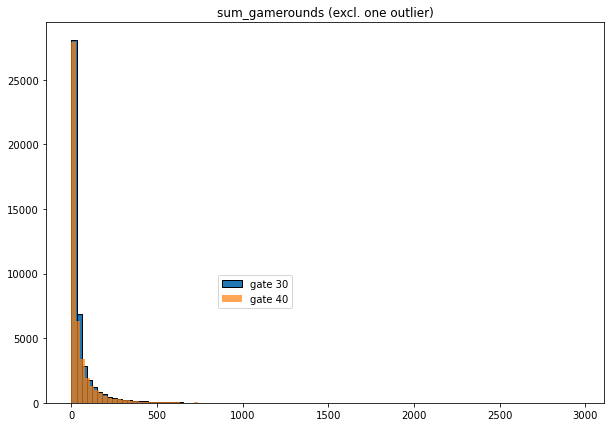

In [42]:
bins = 100
plt.figure(figsize = (10, 7))
plt.hist(gate_30.sum_gamerounds, bins = bins, alpha = 1, edgecolor = 'black', label = 'gate 30')
plt.hist(gate_40.sum_gamerounds, bins = bins, alpha = 0.7, label = 'gate 40')
plt.legend(loc = 'upper right', bbox_to_anchor = (0.45, 0.35))
plt.title('sum_gamerounds (excl. one outlier)')
plt.show()

In sample_2 (with exclusion of extreme outliers) histograms look very similar. In the area of 30-40 level frequencies of the control group are a bit higher than of the test. Probably it means that if the effect of gate location at 30-40 level is present then it does not last long. Maybe, in addition, it makes sense to test the data truncated at 30-60 levels.

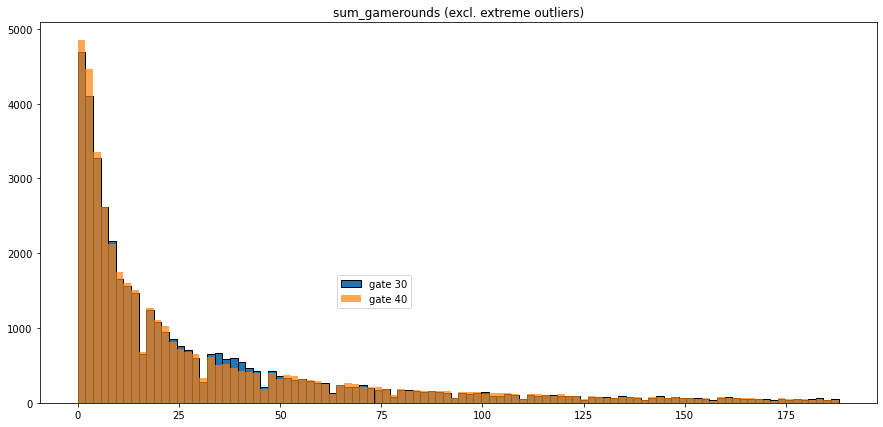

In [43]:
bins = 100
plt.figure(figsize = (15, 7))
plt.hist(gate_30_2.sum_gamerounds, bins = bins, alpha = 1, edgecolor = 'black', label = 'gate 30')
plt.hist(gate_40_2.sum_gamerounds, bins = bins, alpha = 0.7, label = 'gate 40')
plt.legend(loc = 'upper right', bbox_to_anchor = (0.45, 0.35))
plt.title('sum_gamerounds (excl. extreme outliers)')
plt.show()

Average number of rounds is almost the same between control and test groups:

In [44]:
print('average number of rounds in control group', gate_30.sum_gamerounds.mean())
print('average number of rounds in test group', gate_40.sum_gamerounds.mean())

average number of rounds in control group 51.342110561757536
average number of rounds in test group 51.29877552814966


Distributions in both groups are asymmetric and not similar to normal. But every group has about 45k players, so rely on Central Limit Theorem and assume distributions of average numbers normal:

In [45]:
print(gate_30.shape)
print(gate_40.shape)

(44699, 5)
(45489, 5)


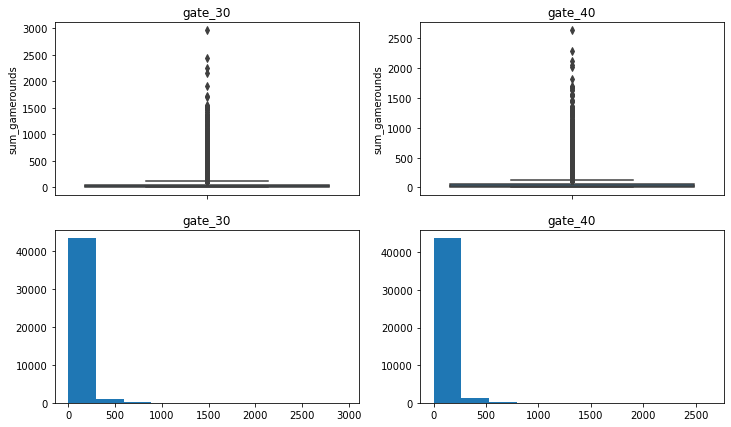

In [46]:
plt.figure(figsize = (12, 7)) 
plt.subplot(2,2,1)
sns.boxplot(y = gate_30.sum_gamerounds);
plt.title('gate_30');
plt.subplot(2,2,2)
sns.boxplot(y = gate_40.sum_gamerounds);
plt.title('gate_40');
plt.subplot(2,2,3)
plt.hist(gate_30.sum_gamerounds);
plt.title('gate_30');
plt.subplot(2,2,4)
plt.hist(gate_40.sum_gamerounds);
plt.title('gate_40');

Variable is numeric, groups are independent, comparison of two means - use Student's t-test for independent samples, one-sided, as direction is important in this case.

Are variances of control and test groups equal? There is almost no difference between sample standard deviations. There is an opinion that if the difference is more than 5%, consider the variances unequal. Another opinion is that Welch correction should not harm in any case. The third one - in case of actually equal variances Welch correction overestimates the probability of type 2 error (fail to reject false H0). Documentation of ttest_ind says that in case of unequal variances absence of correction underestimates p-value. Given almost the same sample standard deviations, we will not apply the correction and try to take all "buts" into account when interpreting the result.

In [47]:
print('sd of number of rounds gate_30 ', gate_30.sum_gamerounds.std())
print('sd of number of rounds gate_40 ', gate_40.sum_gamerounds.std())
print('relative difference in sd ', (gate_40.sum_gamerounds.std() - gate_30.sum_gamerounds.std()) /
      gate_30.sum_gamerounds.std())

sd of number of rounds gate_30  102.05759789214098
sd of number of rounds gate_40  103.29441621653784
relative difference in sd  0.01211882652484129


t-test:

In [48]:
t,p = stats.ttest_ind(gate_40.sum_gamerounds, gate_30.sum_gamerounds, alternative = 'greater', equal_var = False)
print(t,p)

-0.06337426312892294 0.5252656892267771


* If H0 is true (average number of rounds in test group is equal to or lower than in control), the data does not contradict the H0
* If H0 is true, the probability of seeing this test statistic (or something more extreme) is about 53%
* The data shows enough evidence in favor of the Null
* Fail to reject H0 in favor of H1
* Average number of rounds in test group is equal to or lower than in control group. There is no sense to move the gate from level 30 to level 40 with the purpose of increasing the number of played rounds.

As we did not apply Welch correction for the case of unequal variances, there is a risk that p-value is underestimated (if variances are actually equal). But in this case p-value is so high, that the risk of it's underestimation does not matter. If we conduct test with correction as a robustness check, the result is almost the same:

In [49]:
t,p = stats.ttest_ind(gate_40.sum_gamerounds, gate_30.sum_gamerounds, alternative = 'greater', equal_var = True)
print(t,p)

-0.0633675766982082 0.5252630270872


One more robustness check - conduct test for the sample_2. P-value is lower (43%), but there is still enough evidence for H0.

In [50]:
print('average number of rounds in control group excl. extreme outliers', gate_30_2.sum_gamerounds.mean())
print('average number of rounds in test group excl. extreme outliers', gate_40_2.sum_gamerounds.mean())

average number of rounds in control group excl. extreme outliers 30.60203179156209
average number of rounds in test group excl. extreme outliers 30.648941662364482


In [51]:
t,p = stats.ttest_ind(gate_40_2.sum_gamerounds, gate_30_2.sum_gamerounds, alternative = 'greater', equal_var = False)
print(t,p)

0.17415619552656236 0.4308715638935539


<a href="#0"><h4>Back to top</h4></a>

<p id="3.2">
<h5>Mann-Whitney u-test</h5><br>

Robustness of test result may be checked to the normality assumption
It is also possible to check the robustness of the test to the assumption of normality and perform the non-parametric Mann-Whitney test. If assuming that equal distributions have equal medians, then: 
<br>
* Null hypothesis: median number of rounds in test group gate_40 is equal to or lower than in control group gate_30
* Alternative hypothesis: median number of rounds in test group is higher than in control group

Sample median in control group is a bit higher than in test - 17 vs 16:

In [52]:
data_1.groupby('version').median('sum_gamerounds')['sum_gamerounds']

version
gate_30    17.0
gate_40    16.0
Name: sum_gamerounds, dtype: float64

Mann-Whitney test:

In [53]:
stat, p = stats.mannwhitneyu(gate_40.sum_gamerounds, gate_30.sum_gamerounds, alternative = 'greater')
stat, p

(1009027049.5, 0.97455423878383)

* If H0 is true (median number of rounds in test group is equal to or lower than in control), the data does not contradict the H0
* If H0 is true, the probability of seeing this test statistic (or something more extreme) is about 97%
* The data shows enough evidence in favor of the Null
* Fail to reject H0 in favor of H1
* Median number of rounds in the test group is equal to or lower than in the control group. There is no sense to move the gate from level 30 to level 40 with the purpose of increasing the number of played rounds.

<a href="#0"><h4>Back to top</h4></a>

<p id="3.3">
<h5>Student's t-test and log transformation</h5><br>

Log-transformation of such skewed to the right distribution may look more like the normal distribution. 

As found above, there are 3994 players with 0 number of rounds. They need to be excluded for the log-transformation:

In [54]:
len(data[data['sum_gamerounds'] == 0])

3994

In [55]:
data_log = data.loc[:]
data_log = data_log[data_log['sum_gamerounds'] > 0]

Add the column with natural logarithm of sum_gamerounds:

In [56]:
data_log['log_sum_rounds'] = np.log(data_log['sum_gamerounds'])
data_log.head()

,userid,version,sum_gamerounds,retention_1,retention_7,log_sum_rounds
0,116,gate_30,3,False,False,1.098612
1,337,gate_30,38,True,False,3.637586
2,377,gate_40,165,True,False,5.105945
3,483,gate_40,1,False,False,0.000000
4,488,gate_40,179,True,True,5.187386


Now histogram looks more like a normal:

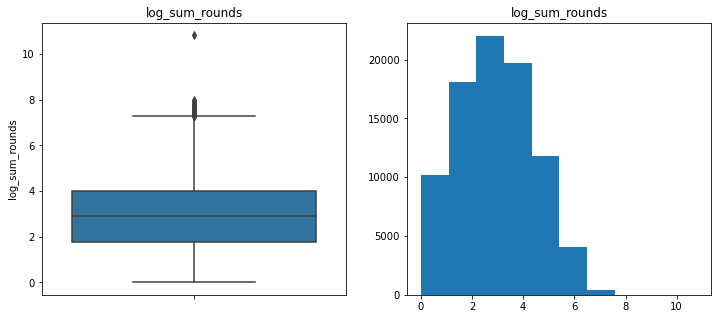

In [57]:
plt.figure(figsize = (12, 5)) 
plt.subplot(1,2,1)
sns.boxplot(y = data_log.log_sum_rounds);
plt.title('log_sum_rounds');
plt.subplot(1,2,2)
plt.hist(data_log.log_sum_rounds);
plt.title('log_sum_rounds');

Exclude the outlier sum_gamerounds = 49854:

In [58]:
data_log_1 = data_log[data_log.sum_gamerounds < data_log.sum_gamerounds.max()]

Histogram and boxplot without the outlier:

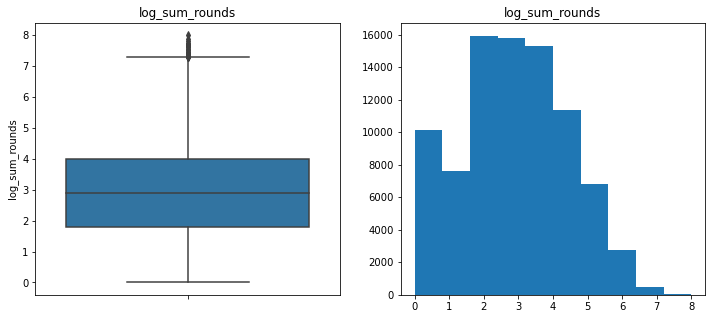

In [59]:
plt.figure(figsize = (12, 5)) 
plt.subplot(1,2,1)
sns.boxplot(y = data_log_1.log_sum_rounds);
plt.title('log_sum_rounds');
plt.subplot(1,2,2)
plt.hist(data_log_1.log_sum_rounds);
plt.title('log_sum_rounds');

What if exclude extreme outliers (sum_gamerounds > 189):

In [60]:
data_log_2 = data_log[data_log.sum_gamerounds < 189]

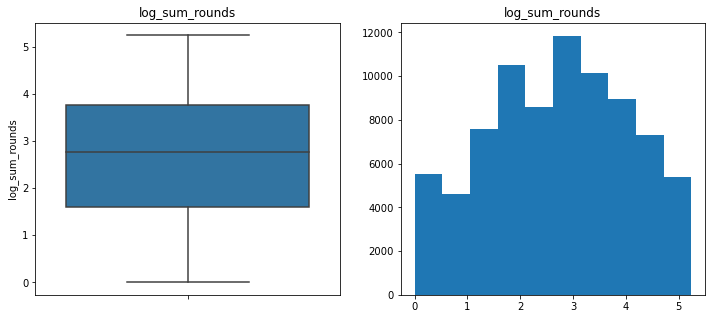

In [61]:
plt.figure(figsize = (12, 5)) 
plt.subplot(1,2,1)
sns.boxplot(y = data_log_2.log_sum_rounds);
plt.title('log_sum_rounds');
plt.subplot(1,2,2)
plt.hist(data_log_2.log_sum_rounds);
plt.title('log_sum_rounds');

Split the data (without zero rounds and one outlier) in control and test groups:

In [62]:
gate_30_log = data_log_1[data_log_1.version == 'gate_30']
gate_40_log = data_log_1[data_log_1.version == 'gate_40']

Split the data (without zero rounds and extreme outliers) in control and test groups:

In [63]:
gate_30_log_2 = data_log_2[data_log_2.version == 'gate_30']
gate_40_log_2 = data_log_2[data_log_2.version == 'gate_40']

Formulate the hypotheses:<br>
* Null hypothesis: average logarithm of number of rounds in test group gate_40 is equal to or lower than in control group gate_30
* Alternative hypothesis: average logarithm of number of rounds in test group is higher than in control group

Averages in groups are almost equal, a bit higher in control group:

In [64]:
print('average logarithm of number of rounds in control group', gate_30_log.log_sum_rounds.mean())
print('average logarithm of number of rounds in test group', gate_40_log.log_sum_rounds.mean())

average logarithm of number of rounds in control group 2.8895630046553813
average logarithm of number of rounds in test group 2.87454313039857


Are variances in control and test group equal? Almost no difference between sample standard deviations. Will not apply Welch correction and try to take all "buts" into account when interpreting the result.

In [65]:
print('sd of number of rounds gate_30 ', gate_30_log.log_sum_rounds.std())
print('sd of number of rounds gate_40 ', gate_40_log.log_sum_rounds.std())
print('relative difference in sd ', (gate_40_log.log_sum_rounds.std() - gate_30_log.log_sum_rounds.std()) /
      gate_30_log.log_sum_rounds.std())

sd of number of rounds gate_30  1.5413621223499008
sd of number of rounds gate_40  1.5518205519748396
relative difference in sd  0.006785186604296659


Student's t-test:

In [66]:
t,p = stats.ttest_ind(gate_40_log.log_sum_rounds, gate_30_log.log_sum_rounds, alternative = 'greater', equal_var = False)
print(t,p)

-1.4255913668463311 0.9230050243427721


* If H0 is true (average logarithm of number of rounds in test group is equal to or lower than in control), the data does not contradict the H0
* If H0 is true, the probability of seeing this test statistic (or something more extreme) is about 92%
* The data shows enough evidence in favor of the Null
* Fail to reject H0 in favor of H1
* Average logarithm of number of rounds in test group is equal to or lower than in control group. 

Test conducted on data without extreme outliers shows almost the same result:

In [67]:
t,p = stats.ttest_ind(gate_40_log_2.log_sum_rounds, gate_30_log_2.log_sum_rounds, alternative = 'greater', equal_var = False)
print(t,p)

-1.4002338223846083 0.9192764163885482


<a href="#0"><h4>Back to top</h4></a>

<p id="4">
<h4>Conclusion</h4><br>

* Pearson's chi-squared has not shown statistically significant difference between returned/not returned 1 day later players and location of gate. Practically this difference is also insignificant: 0.448 retention share for gate_30 и 0.442 for gate_40.
* Pearson's chi-squared has shown statistically significant difference between returned/not returned 7 days later players and location of gate. But practically this difference is quite insignificant: 0.19 retention share for gate_30 и 0.182 for gate_40.
* Student's t-test had failed to reject the hypothesis that the average number of rounds for gate_40 is equal to or lower than for gate_30. Practically the difference is also insignificant: 51.34 for gate_30 and 51.29 for gate_40.
* Student's t-test result has shown robustness to exclusion of extreme outliers and assumption of normal distribution.
* There is no sense to move gate from level 30 to level 40 with the purpose of increase in retention or number of played rounds.